In [2]:
import pandas as pd
import numpy as np
import pandas_ta as ta
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')


In [22]:
class PnlCalulator:
    def __init__(self,target):
        self.intrade_long = False
        self.intrade_short = False
        self.sl = 0
        self.entry_price = 0
        self.multiplier = target
        self.atr = 0
    
    def Crossover(self):

        df = pd.read_csv('btc_3m_2019-24.csv')
        #df = df.rename(columns ={"signal":"signals","datetime":"timestamp"})
        df['ATR'] = ta.atr(df.high, df.low, df.close, window=14)
        df['target_points'] = None
        df['remarks'] = 'Algo_Exit'

        df['HA_Close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4
        df['HA_Open'] = (df['open'] + df['close']) / 2
        df['HA_Open'] = df['HA_Open'].shift(1)  # Shift to use previous period's values
        df['HA_Open'].iloc[0] = df['open'].iloc[0]  # First HA Open is the same as the first original open
        df['HA_High'] = df[['HA_Open', 'HA_Close']].join(df['high']).max(axis=1)
        df['HA_Low'] = df[['HA_Open', 'HA_Close']].join(df['low']).min(axis=1)

        df["Short_MA"] = df["close"].rolling(window=1).mean()
        df["Long_MA"] = df["close"].rolling(window=1259).mean()
        df["sma_long_minus_short"] = df["Long_MA"] - df["Short_MA"]
        df['region'] = df['sma_long_minus_short'].apply(lambda x: 'Short_Region' if x > 0 else 'Long_Region')
        df['mask_1'] = (df['region'] == 'Long_Region') & (df['region'].shift(1) == 'Short_Region')
        df['mask_2'] = (df['region'] == 'Short_Region') & (df['region'].shift(1) == 'Long_Region')
        df['crossover_detection'] = df.apply(lambda row: True if row['mask_1'] else False if row['mask_2'] else row['region'], axis=1)
        df['signal'] = df['crossover_detection'].apply(lambda x: 1 if x == True else 2 if x == False else 0)

        in_trade_long, in_trade_short = False, False
        for i in tqdm(range(len(df))):
            if df['signal'].iloc[i] == 2 and in_trade_long:
                df.at[i-1,'signal'] = -1
                in_trade_long = False
                in_trade_short = True
            elif df['signal'].iloc[i] == 1 and in_trade_short:
                df.at[i-1,'signal'] = -2
                in_trade_long = True
                in_trade_short = False
            elif df['signal'].iloc[i] == 2 and not in_trade_short:
                in_trade_short = True
            elif df['signal'].iloc[i] == 1 and not in_trade_long:
                in_trade_long = True
            
        
        target_points = 0
        entry_price = 0
        sl = 0
        tp = 0
        
        for i in tqdm(range(len(df))):
            if df['signal'].iloc[i] == 1:
                entry_price = df['close'].iloc[i]
                df.at[i, 'target_points'] = self.multiplier * df['ATR'].iloc[i]
                target_points = df['target_points'].iloc[i]
                sl = df['close'].iloc[i] - df['target_points'].iloc[i]
                intrade = True
                
                
            elif df['signal'].iloc[i] == 2:
                entry_price = df['close'].iloc[i]
                df.at[i, 'target_points'] = 11 * df['ATR'].iloc[i]
                target_points = df['target_points'].iloc[i]
                sl = df['close'].iloc[i] + df['target_points'].iloc[i]
                intrade = True
                k = i
                mul = 1
                while k < len(df) and df['signal'].iloc[k] != -2 and intrade:
                    if df['close'].iloc[k] < entry_price-(0.02)*mul*entry_price:
                        new_sl = entry_price - (0.009) *mul* entry_price
                        if new_sl < sl:
                            sl = new_sl
                        mul = mul+1
                    elif df['low'].iloc[k] < sl < df['high'].iloc[k]:
                        df.at[k, 'signal'] = -2
                        df.at[k, 'remarks'] = "SL_Exit"
                        intrade = False
                    k += 1


        d = df[df['signal'] != 0]

        # filtering out repetitive signals
        signal = []
        prev = None
        for value in d["signal"]:
            if value == prev:
                signal.append(0)
            else:
                signal.append(value)
                prev = value

        d["signal"] = signal
        dg = d[d['signal']!=0]

        # creation of PnL file from logs 
        dg['entry_timestamp']= dg['timestamp'] 
        dg['entry_price']= dg['close']
        dg['exit_timestamp']= dg['timestamp'].shift(-1)
        dg['exit_price']= dg['close'].shift(-1)
        dg['remarks']= dg['remarks'].shift(-1)
        pnl= dg[dg['signal']>0][['entry_timestamp', 'entry_price', 'exit_timestamp', 'exit_price', 'signal','target_points','remarks']]

        #calculatig the Overall PnL
        pnl['profit_per_btc'] = np.where(pnl['signal'] == 1, pnl['exit_price'] - pnl['entry_price'], 
                                        np.where(pnl['signal'] == 2, pnl['entry_price'] - pnl['exit_price'], None)) 
        pnl['capital']= 1000
        pnl['#units']= pnl['capital']/pnl['entry_price']
        pnl['profit_per_capital']= pnl['#units']*pnl['profit_per_btc']
        pnl['tnc_cost']= 1
        pnl['profit_after_tnc']= pnl['profit_per_capital']- pnl['tnc_cost']
        pnl['cumulative_profit']= pnl['profit_after_tnc'].cumsum()
        pnl['roe_%']= (pnl['profit_after_tnc']/pnl['capital'])*100
        net_pnl = pnl.reset_index()
            

        return  net_pnl, net_pnl['profit_after_tnc'].sum()

if __name__ == "__main__":
    pnl_calculator = PnlCalulator(target=11)  # Create an instance of PnlCalculator
    obj, net_pnl_amount = pnl_calculator.Crossover()
    
    obj.to_csv('pnl_since_2019.csv', index= False) 
    print("Net PnL:", net_pnl_amount) 
            

100%|██████████| 956734/956734 [00:25<00:00, 37939.80it/s]


Net PnL: 14765.208215050283


In [9]:
def optimize_pnl_calculator(num_simulations, batch_size):
    results = pd.DataFrame()
    for _ in range(num_simulations):
        #sma_short = np.random.randint(1, 1000)  # Example range for SMA short period
        #sma_long = np.random.randint(1, 2000)  # Example range for SMA long period
        #print('sma_long', sma_long)
        #print('sma_short', sma_short)
        
        target = np.random.randint(5, 50)  # Example range for target
        print('target', target)
        pnl_calculator = PnlCalulator(target=target)  # Create an instance of PnlCalculator
        obj,net_pnl = pnl_calculator.Crossover()  # Assuming crossover_tp is defined in PnlCalculator
        print('pnl', net_pnl)
        pd.options.mode.chained_assignment = None
        results_temp = pd.DataFrame({
                             'target': [target],
                             'pnl': [net_pnl]},
                            index=[0])

#         results_temp = pd.DataFrame({'sma_short': sma_short,
#                              'sma_long': sma_long,
#                              'target': target,
#                              'pnl': pnl})
#         results_temp= pd.DataFrame(sma_short,sma_long,target,pnl, columns=['sma_short', 'sma_long', 'target', 'pnl'])
        results= pd.concat([results,results_temp])
#         results = 

#         results= pd.
        results.to_csv('simulations_cso_1.csv', index= False)
    return results

# Example usage
num_simulations = 5000
batch_size = 20

simulation_results = optimize_pnl_calculator(num_simulations, batch_size)

target 23


100%|██████████| 700501/700501 [00:22<00:00, 30895.72it/s]


pnl 2941.2467339886466
target 27


100%|██████████| 700501/700501 [00:23<00:00, 29828.90it/s]


pnl 2357.333582814703
target 35


100%|██████████| 700501/700501 [00:23<00:00, 29759.32it/s]


pnl 2506.9973904210333
target 29


100%|██████████| 700501/700501 [00:23<00:00, 30418.72it/s]


pnl 2423.5785867839495
target 47


100%|██████████| 700501/700501 [00:24<00:00, 29177.81it/s]


pnl 2574.1523595280255
target 37


100%|██████████| 700501/700501 [00:26<00:00, 26281.25it/s]


pnl 2587.285503629695
target 48


100%|██████████| 700501/700501 [00:24<00:00, 28849.10it/s]


pnl 2603.953961349963
target 21


100%|██████████| 700501/700501 [00:22<00:00, 30817.37it/s]


pnl 3054.9871137565683
target 16


100%|██████████| 700501/700501 [00:20<00:00, 34207.95it/s]


pnl 2685.92607690749
target 46


100%|██████████| 700501/700501 [00:22<00:00, 31717.39it/s]


pnl 2630.556903613478
target 43


100%|██████████| 700501/700501 [00:24<00:00, 28548.54it/s]


pnl 2680.254469668458
target 33


100%|██████████| 700501/700501 [00:25<00:00, 27363.66it/s]


pnl 2536.0032483178156
target 35


100%|██████████| 700501/700501 [00:24<00:00, 28727.26it/s]


pnl 2506.9973904210333
target 33


100%|██████████| 700501/700501 [00:24<00:00, 28839.07it/s]


pnl 2536.0032483178156
target 16


100%|██████████| 700501/700501 [00:23<00:00, 30418.40it/s]


pnl 2685.92607690749
target 19


100%|██████████| 700501/700501 [00:22<00:00, 30789.08it/s]


pnl 2754.6846759960313
target 36


100%|██████████| 700501/700501 [00:21<00:00, 33127.32it/s]


pnl 2549.4168032859493
target 28


100%|██████████| 700501/700501 [00:21<00:00, 33059.64it/s]


pnl 2319.4959736762294
target 40


100%|██████████| 700501/700501 [00:23<00:00, 30136.70it/s]


pnl 2732.3027454264984
target 25


100%|██████████| 700501/700501 [00:23<00:00, 29893.17it/s]


pnl 2834.7014070586256
target 26


100%|██████████| 700501/700501 [00:20<00:00, 33890.50it/s]


pnl 2856.1058015383705
target 28


100%|██████████| 700501/700501 [00:20<00:00, 33784.87it/s]


pnl 2319.4959736762294
target 29


100%|██████████| 700501/700501 [00:23<00:00, 29804.00it/s]


pnl 2423.5785867839495
target 49


100%|██████████| 700501/700501 [00:23<00:00, 29642.98it/s]


pnl 2653.3451140536936
target 46


100%|██████████| 700501/700501 [00:24<00:00, 29147.06it/s]


pnl 2630.556903613478
target 27


100%|██████████| 700501/700501 [00:23<00:00, 30062.70it/s]


pnl 2357.333582814703
target 38


100%|██████████| 700501/700501 [00:22<00:00, 31613.49it/s]


pnl 2642.1110092191752
target 29


100%|██████████| 700501/700501 [00:22<00:00, 30724.76it/s]


pnl 2423.5785867839495
target 42


100%|██████████| 700501/700501 [00:23<00:00, 30158.95it/s]


pnl 2658.5488200850245
target 7


100%|██████████| 700501/700501 [00:19<00:00, 36608.75it/s]


pnl 2564.4775673908252
target 44


100%|██████████| 700501/700501 [00:23<00:00, 29229.88it/s]


pnl 2599.4167943061384
target 26


100%|██████████| 700501/700501 [00:22<00:00, 30964.62it/s]


pnl 2856.1058015383705
target 46


100%|██████████| 700501/700501 [00:24<00:00, 28923.40it/s]


pnl 2630.556903613478
target 12


100%|██████████| 700501/700501 [00:20<00:00, 34017.43it/s]


pnl 2542.973264911318
target 31


100%|██████████| 700501/700501 [00:23<00:00, 29328.67it/s]


pnl 2396.945691521435
target 20


100%|██████████| 700501/700501 [00:24<00:00, 29165.74it/s]


pnl 2884.7212676441363
target 20


100%|██████████| 700501/700501 [00:21<00:00, 32551.07it/s]


pnl 2884.7212676441363
target 19


100%|██████████| 700501/700501 [00:22<00:00, 31467.99it/s]


pnl 2754.6846759960313
target 15


100%|██████████| 700501/700501 [00:21<00:00, 32602.32it/s]


pnl 2737.09712268356
target 37


100%|██████████| 700501/700501 [00:23<00:00, 30215.92it/s]


pnl 2587.285503629695
target 34


100%|██████████| 700501/700501 [00:23<00:00, 30123.85it/s]


pnl 2552.746352573771
target 20


100%|██████████| 700501/700501 [00:21<00:00, 32198.74it/s]


pnl 2884.7212676441363
target 25


100%|██████████| 700501/700501 [00:23<00:00, 30416.26it/s]


pnl 2834.7014070586256
target 41


100%|██████████| 700501/700501 [00:24<00:00, 28080.60it/s]


pnl 2627.2268775836656
target 37


100%|██████████| 700501/700501 [00:26<00:00, 26557.00it/s]


pnl 2587.285503629695
target 8


100%|██████████| 700501/700501 [00:19<00:00, 36579.66it/s]


pnl 2642.6915909165778
target 18


100%|██████████| 700501/700501 [00:21<00:00, 31979.84it/s]


pnl 2783.6069972893547
target 37


100%|██████████| 700501/700501 [00:25<00:00, 27684.44it/s]


pnl 2587.285503629695
target 36


100%|██████████| 700501/700501 [00:23<00:00, 30007.39it/s]


pnl 2549.4168032859493
target 34


100%|██████████| 700501/700501 [00:23<00:00, 30124.65it/s]


pnl 2552.746352573771
target 39


100%|██████████| 700501/700501 [00:23<00:00, 29346.83it/s]


pnl 2706.697953711898
target 34


100%|██████████| 700501/700501 [00:22<00:00, 30561.50it/s]


pnl 2552.746352573771
target 27


100%|██████████| 700501/700501 [00:25<00:00, 27915.10it/s]


pnl 2357.333582814703
target 16


100%|██████████| 700501/700501 [00:25<00:00, 27248.03it/s]


pnl 2685.92607690749
target 21


100%|██████████| 700501/700501 [00:27<00:00, 25094.66it/s]


pnl 3054.9871137565683
target 46


100%|██████████| 700501/700501 [00:23<00:00, 30028.89it/s]


pnl 2630.556903613478
target 45


100%|██████████| 700501/700501 [00:23<00:00, 29966.15it/s]


pnl 2608.2652938856386
target 10


100%|██████████| 700501/700501 [00:18<00:00, 37900.91it/s]


pnl 2590.5823311909962
target 42


100%|██████████| 700501/700501 [00:22<00:00, 30943.87it/s]


pnl 2658.5488200850245
target 16


100%|██████████| 700501/700501 [00:20<00:00, 34219.44it/s]


pnl 2685.92607690749
target 13


100%|██████████| 700501/700501 [00:19<00:00, 35857.85it/s]


pnl 2559.8699514158448
target 10


100%|██████████| 700501/700501 [00:19<00:00, 35847.89it/s]


pnl 2590.5823311909962
target 14


100%|██████████| 700501/700501 [00:19<00:00, 35438.83it/s]


pnl 2533.0581764753947
target 31


100%|██████████| 700501/700501 [00:21<00:00, 32433.47it/s]


pnl 2396.945691521435
target 9


100%|██████████| 700501/700501 [00:18<00:00, 38027.47it/s]


pnl 2669.3383590427165
target 38


100%|██████████| 700501/700501 [00:23<00:00, 29401.87it/s]


pnl 2642.1110092191752
target 43


100%|██████████| 700501/700501 [00:24<00:00, 29071.49it/s]


pnl 2680.254469668458
target 38


100%|██████████| 700501/700501 [00:22<00:00, 31277.87it/s]


pnl 2642.1110092191752
target 36


100%|██████████| 700501/700501 [00:22<00:00, 30507.76it/s]


pnl 2549.4168032859493
target 48


100%|██████████| 700501/700501 [00:23<00:00, 29585.10it/s]


pnl 2603.953961349963
target 33


100%|██████████| 700501/700501 [00:24<00:00, 28262.78it/s]


pnl 2536.0032483178156
target 49


100%|██████████| 700501/700501 [00:22<00:00, 30699.72it/s]


pnl 2653.3451140536936
target 14


100%|██████████| 700501/700501 [00:20<00:00, 34987.72it/s]


pnl 2533.0581764753947
target 5


100%|██████████| 700501/700501 [00:17<00:00, 39908.85it/s]


pnl 2263.4914484783344
target 30


100%|██████████| 700501/700501 [00:28<00:00, 24330.52it/s]


pnl 2417.1497853689434
target 28


100%|██████████| 700501/700501 [00:30<00:00, 23332.72it/s]


pnl 2319.4959736762294
target 10


100%|██████████| 700501/700501 [00:22<00:00, 31037.87it/s]


pnl 2590.5823311909962
target 14


100%|██████████| 700501/700501 [00:23<00:00, 29993.01it/s]


pnl 2533.0581764753947
target 48


100%|██████████| 700501/700501 [00:27<00:00, 25346.52it/s]


pnl 2603.953961349963
target 31


100%|██████████| 700501/700501 [00:25<00:00, 27011.82it/s]


pnl 2396.945691521435
target 45


100%|██████████| 700501/700501 [00:26<00:00, 26179.49it/s]


pnl 2608.2652938856386
target 28


100%|██████████| 700501/700501 [00:26<00:00, 26314.23it/s]


pnl 2319.4959736762294
target 49


100%|██████████| 700501/700501 [00:30<00:00, 23206.61it/s]


pnl 2653.3451140536936
target 48


100%|██████████| 700501/700501 [00:30<00:00, 22869.72it/s]


pnl 2603.953961349963
target 44


100%|██████████| 700501/700501 [00:30<00:00, 22704.48it/s]


pnl 2599.4167943061384
target 11


100%|██████████| 700501/700501 [00:26<00:00, 26235.91it/s]


pnl 2850.993233714
target 41


100%|██████████| 700501/700501 [00:30<00:00, 22991.28it/s]


pnl 2627.2268775836656
target 47


100%|██████████| 700501/700501 [00:28<00:00, 24656.96it/s]


pnl 2574.1523595280255
target 37


100%|██████████| 700501/700501 [00:27<00:00, 25777.67it/s]


pnl 2587.285503629695
target 32


100%|██████████| 700501/700501 [00:26<00:00, 26706.92it/s]


pnl 2446.58709565396
target 33


100%|██████████| 700501/700501 [00:29<00:00, 24116.56it/s]


pnl 2536.0032483178156
target 39


100%|██████████| 700501/700501 [00:29<00:00, 24000.21it/s]


pnl 2706.697953711898
target 39


100%|██████████| 700501/700501 [00:27<00:00, 25131.42it/s]


pnl 2706.697953711898
target 34


100%|██████████| 700501/700501 [00:27<00:00, 25256.40it/s]


pnl 2552.746352573771
target 28


100%|██████████| 700501/700501 [00:27<00:00, 25249.02it/s]


pnl 2319.4959736762294
target 24


100%|██████████| 700501/700501 [00:25<00:00, 27112.68it/s]


pnl 2826.3074404893587
target 18


100%|██████████| 700501/700501 [00:24<00:00, 28698.79it/s]


pnl 2783.6069972893547
target 29


100%|██████████| 700501/700501 [00:26<00:00, 26727.99it/s]


pnl 2423.5785867839495
target 5


100%|██████████| 700501/700501 [00:22<00:00, 31153.60it/s]


pnl 2263.4914484783344
target 40


100%|██████████| 700501/700501 [00:26<00:00, 26152.75it/s]


pnl 2732.3027454264984
target 14


100%|██████████| 700501/700501 [00:23<00:00, 29310.74it/s]


pnl 2533.0581764753947
target 39


100%|██████████| 700501/700501 [00:27<00:00, 25370.65it/s]


pnl 2706.697953711898
target 46


100%|██████████| 700501/700501 [00:26<00:00, 26041.98it/s]


pnl 2630.556903613478
target 11


100%|██████████| 700501/700501 [00:21<00:00, 33222.55it/s]


pnl 2850.993233714
target 20


100%|██████████| 700501/700501 [00:23<00:00, 29453.04it/s]


pnl 2884.7212676441363
target 34


100%|██████████| 700501/700501 [00:25<00:00, 27333.63it/s]


pnl 2552.746352573771
target 24


100%|██████████| 700501/700501 [00:24<00:00, 28613.16it/s]


pnl 2826.3074404893587
target 13


100%|██████████| 700501/700501 [00:22<00:00, 31527.96it/s]


pnl 2559.8699514158448
target 23


100%|██████████| 700501/700501 [00:24<00:00, 28962.75it/s]


pnl 2941.2467339886466
target 6


100%|██████████| 700501/700501 [00:19<00:00, 35256.50it/s]


pnl 2550.3932754493444
target 18


100%|██████████| 700501/700501 [00:23<00:00, 30080.78it/s]


pnl 2783.6069972893547
target 10


100%|██████████| 700501/700501 [00:21<00:00, 32926.24it/s]


pnl 2590.5823311909962
target 19


100%|██████████| 700501/700501 [00:23<00:00, 30113.10it/s]


pnl 2754.6846759960313
target 28


100%|██████████| 700501/700501 [00:22<00:00, 31609.59it/s]


pnl 2319.4959736762294
target 8


100%|██████████| 700501/700501 [00:20<00:00, 34521.55it/s]


pnl 2642.6915909165778
target 11


100%|██████████| 700501/700501 [00:19<00:00, 36626.46it/s]


pnl 2850.993233714
target 9


100%|██████████| 700501/700501 [00:18<00:00, 37494.82it/s]


pnl 2669.3383590427165
target 29


100%|██████████| 700501/700501 [00:22<00:00, 31154.57it/s]


pnl 2423.5785867839495
target 19


100%|██████████| 700501/700501 [00:20<00:00, 33644.02it/s]


pnl 2754.6846759960313
target 26


100%|██████████| 700501/700501 [00:23<00:00, 29840.55it/s]


pnl 2856.1058015383705
target 30


100%|██████████| 700501/700501 [00:22<00:00, 31608.58it/s]


pnl 2417.1497853689434
target 30


100%|██████████| 700501/700501 [00:22<00:00, 31638.63it/s]


pnl 2417.1497853689434
target 19


100%|██████████| 700501/700501 [00:20<00:00, 33914.31it/s]


pnl 2754.6846759960313
target 32


100%|██████████| 700501/700501 [00:22<00:00, 31693.87it/s]


pnl 2446.58709565396
target 47


100%|██████████| 700501/700501 [00:24<00:00, 28683.66it/s]


pnl 2574.1523595280255
target 32


100%|██████████| 700501/700501 [00:22<00:00, 30673.75it/s]


pnl 2446.58709565396
target 10


100%|██████████| 700501/700501 [00:18<00:00, 37461.91it/s]


pnl 2590.5823311909962
target 25


100%|██████████| 700501/700501 [00:20<00:00, 33746.96it/s]


pnl 2834.7014070586256
target 17


100%|██████████| 700501/700501 [00:19<00:00, 35079.68it/s]


pnl 2808.2960518951654
target 13


100%|██████████| 700501/700501 [00:19<00:00, 35025.52it/s]


pnl 2559.8699514158448
target 25


100%|██████████| 700501/700501 [00:22<00:00, 30547.14it/s]


pnl 2834.7014070586256
target 23


100%|██████████| 700501/700501 [00:21<00:00, 32907.93it/s]


pnl 2941.2467339886466
target 29


100%|██████████| 700501/700501 [00:21<00:00, 33102.03it/s]


pnl 2423.5785867839495
target 23


100%|██████████| 700501/700501 [00:21<00:00, 32981.04it/s]


pnl 2941.2467339886466
target 23


100%|██████████| 700501/700501 [00:21<00:00, 32808.93it/s]


pnl 2941.2467339886466
target 6


100%|██████████| 700501/700501 [00:20<00:00, 34711.45it/s]


pnl 2550.3932754493444
target 34


100%|██████████| 700501/700501 [00:23<00:00, 29810.01it/s]


pnl 2552.746352573771
target 28


100%|██████████| 700501/700501 [00:21<00:00, 32493.81it/s]


pnl 2319.4959736762294
target 48


100%|██████████| 700501/700501 [00:22<00:00, 30949.59it/s]


pnl 2603.953961349963
target 25


100%|██████████| 700501/700501 [00:23<00:00, 30243.98it/s]


pnl 2834.7014070586256
target 46


100%|██████████| 700501/700501 [00:25<00:00, 26951.03it/s]


pnl 2630.556903613478
target 12


100%|██████████| 700501/700501 [00:22<00:00, 31257.11it/s]


pnl 2542.973264911318
target 22


100%|██████████| 700501/700501 [00:24<00:00, 28250.57it/s]


pnl 3009.685980290699
target 19


100%|██████████| 700501/700501 [00:23<00:00, 29316.64it/s]


pnl 2754.6846759960313
target 12


100%|██████████| 700501/700501 [00:22<00:00, 30869.71it/s]


pnl 2542.973264911318
target 31


100%|██████████| 700501/700501 [00:25<00:00, 27221.85it/s]


pnl 2396.945691521435
target 28


100%|██████████| 700501/700501 [00:25<00:00, 27655.51it/s]


pnl 2319.4959736762294
target 28


100%|██████████| 700501/700501 [00:25<00:00, 27852.12it/s]


pnl 2319.4959736762294
target 43


100%|██████████| 700501/700501 [00:26<00:00, 26564.47it/s]


pnl 2680.254469668458
target 24


100%|██████████| 700501/700501 [00:24<00:00, 28516.95it/s]


pnl 2826.3074404893587
target 38


100%|██████████| 700501/700501 [00:26<00:00, 26846.13it/s]


pnl 2642.1110092191752
target 37


100%|██████████| 700501/700501 [00:26<00:00, 26222.06it/s]


pnl 2587.285503629695
target 34


100%|██████████| 700501/700501 [00:26<00:00, 26774.90it/s]


pnl 2552.746352573771
target 6


100%|██████████| 700501/700501 [00:20<00:00, 33867.54it/s]


pnl 2550.3932754493444
target 47


100%|██████████| 700501/700501 [00:26<00:00, 25990.42it/s]


pnl 2574.1523595280255
target 31


100%|██████████| 700501/700501 [00:26<00:00, 26875.24it/s]


pnl 2396.945691521435
target 49


 17%|█▋        | 121290/700501 [00:04<00:23, 25142.90it/s]


KeyboardInterrupt: 

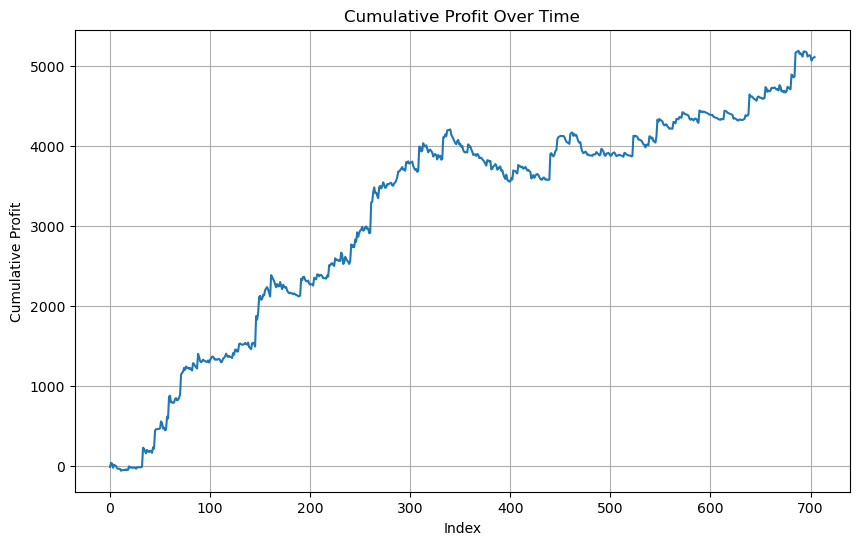

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(obj['cumulative_profit'])
plt.title('Cumulative Profit Over Time')
plt.xlabel('Index')
plt.ylabel('Cumulative Profit')
plt.grid(True)
plt.show()


In [183]:
data_f = []
data_f = pd.DataFrame()
data_f['-ve_roe'] = obj['roe_%'].apply(lambda x:  x if x<0 else None)
data_f.dropna(axis = 0,inplace = True)
mean = data_f['-ve_roe'].mean()
max_drop = data_f['-ve_roe'].min()
print("The Mean Drop is:",mean)
print("The Max Drop is:",max_drop)

The Mean Drop is: -2.293272338984634
The Max Drop is: -11.160881621505373


In [184]:
obj.tail(50)

,index,entry_timestamp,entry_price,exit_timestamp,exit_price,signal,target_points,remarks,profit_per_btc,capital,#units,profit_per_capital,tnc_cost,profit_after_tnc,cumulative_profit,roe_%
494,637405,2023-08-22 18:45:00,26018.61,2023-08-23 21:42:00,26196.00,2,227.270485,SL_Exit,-177.39,1000,0.038434,-6.817812,1,-7.817812,2870.981358,-0.781781
495,638097,2023-08-24 05:21:00,26432.00,2023-08-26 04:18:00,26045.83,1,447.780473,Algo_Exit,-386.17,1000,0.037833,-14.609942,1,-15.609942,2855.371416,-1.560994
496,639037,2023-08-26 04:21:00,26049.62,2023-08-28 09:00:00,26033.15,2,206.236564,Algo_Exit,16.47,1000,0.038388,0.632255,1,-0.367745,2855.00367,-0.036775
497,640091,2023-08-28 09:03:00,26038.05,2023-08-28 16:00:00,25939.97,1,193.864002,Algo_Exit,-98.08,1000,0.038405,-3.766795,1,-4.766795,2850.236875,-0.47668
498,640231,2023-08-28 16:03:00,25943.22,2023-08-28 17:54:00,26223.98,2,198.323683,SL_Exit,-280.76,1000,0.038546,-10.822095,1,-11.822095,2838.41478,-1.18221
499,640276,2023-08-28 18:18:00,26128.57,2023-08-29 18:15:00,26009.14,1,749.218522,Algo_Exit,-119.43,1000,0.038272,-4.570859,1,-5.570859,2832.843921,-0.557086
500,640756,2023-08-29 18:18:00,26013.43,2023-08-29 19:48:00,26687.87,2,240.270736,SL_Exit,-674.44,1000,0.038442,-25.926608,1,-26.926608,2805.917313,-2.692661
501,640791,2023-08-29 20:03:00,27382.04,2023-09-01 09:30:00,26078.83,1,2902.618652,Algo_Exit,-1303.21,1000,0.036520,-47.593605,1,-48.593605,2757.323708,-4.859361
502,642021,2023-09-01 09:33:00,26087.80,2023-09-02 02:00:00,25858.46,2,189.552554,SL_Exit,229.34,1000,0.038332,8.791082,1,7.791082,2765.114791,0.779108
503,643427,2023-09-04 07:51:00,25914.44,2023-09-05 15:45:00,25775.00,1,160.997628,Algo_Exit,-139.44,1000,0.038589,-5.380784,1,-6.380784,2758.734007,-0.638078
